In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
import sympy as sp
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
# Get data from MG5 runs
pclFiles = {'pp->zp': '../data/2mdm_zp_jet.pcl',
            'pp->sd': '../data/2mdm_sd_jet.pcl'}

df = [pd.read_pickle(f) for l, f in pclFiles.items()]

for i, label in enumerate(pclFiles.keys()):
    df[i]['process'] = label
    
    if label == 'pp->zp':
        df[i] = df[i].drop(columns=['$m_{s}$'])
        df[i] = df[i].rename(columns={'$m_{Z^{\prime}}$': '$m_{med}$'})
        
    elif label == 'pp->sd':
        df[i] = df[i].drop(columns=['$m_{Z^{\prime}}$'])
        df[i] = df[i].rename(columns={'$m_{s}$': '$m_{med}$'})
        
    df[i] = df[i].rename(columns={'$\sin\\theta$': '$\sin\\alpha$'})
    
for d in df:
    d = d.sort_values(['process', '$m_{med}$', '$\sin\\alpha$', '$g_{q}$'],inplace=True, 
                     ascending=[True, True, True, True])

In [3]:
data = pd.DataFrame()
for d in df:
    data = pd.concat((data,d))

In [4]:
BRdata = pd.read_pickle('../data/BRdata.pcl')

In [5]:
dataS = data[data['process'] == 'pp->sd']
dataZ = data[data['process'] == 'pp->zp']
brS = BRdata[BRdata['Mediator'] == '$S_{d}$']
brZ = BRdata[BRdata['Mediator'] == '$Z^{\prime}$']

In [6]:
col = ['$m_{med}$', '$\\sin\\alpha$']

keys = list(dataS[col].columns.values)
i1 = dataS.set_index(keys).index
i2 = brS.set_index(keys).index
brS = brS[i2.isin(i1)]

col = ['$m_{med}$', '$g_{q}$']

keys = list(dataZ[col].columns.values)
i1 = dataZ.set_index(keys).index
i2 = brZ.set_index(keys).index
brZ = brZ[i2.isin(i1)]

In [7]:
# Filter models

filter1 = {
           '$y_{\\chi}$': 1.5
          }
filter2 = {
           '$g_{\\chi}$': 0.5
          }
filter3 = {
           '$\\sin\\alpha$': 0.2
          }

filter4 = {
           '$g_{q}$': 0.1
          }

str1 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter1.items()])
str2 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter2.items()])
str3 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter3.items()])
str4 = '\n'.join([r'%s = %s' %(k,v) for k,v in filter4.items()])
textstr = '\n'.join([str1]+[str2]+[str3]+[str4])

In [8]:
dataS = dataS.loc[(dataS[list(filter3)] == pd.Series(filter3)).all(axis=1)]
brS = brS.loc[(brS[list(filter1)] == pd.Series(filter1)).all(axis=1)]
brS = brS.loc[(brS[list(filter3)] == pd.Series(filter3)).all(axis=1)]

dataZ = dataZ.loc[(dataZ[list(filter4)] == pd.Series(filter4)).all(axis=1)]
brZ = brZ.loc[(brZ[list(filter2)] == pd.Series(filter2)).all(axis=1)]
brZ = brZ.loc[(brZ[list(filter4)] == pd.Series(filter4)).all(axis=1)]

print(len(dataS), len(brS), len(dataZ), len(brZ))

14 14 26 26


In [9]:
xsecs = pd.DataFrame(columns=['$m_{s}$', '$m_{Zp}$'])
for mzp in dataZ['$m_{med}$']:
    for ms in dataS['$m_{med}$']:
        xsecs.loc[len(xsecs)] = [ms, mzp]

In [10]:
vals, valscut = [], []
for mzp in dataZ['$m_{med}$']:
    for ms in dataS['$m_{med}$']:
        
        xsecS = float(dataS[dataS['$m_{med}$'] == ms]['x-sec (pb)'])*float(brS[brS['$m_{med}$'] == ms]['$BR(med>\\chi\\chi)$'])
        xsecZp = float(dataZ[dataZ['$m_{med}$'] == mzp]['x-sec (pb)'])*float(brZ[brZ['$m_{med}$'] == mzp]['$BR(med>\\chi\\chi)$'])
        vals.append(xsecS/xsecZp)
        
        xsecScut = float(dataS[dataS['$m_{med}$'] == ms]['x-sec pT-250 (pb)'])*float(brS[brS['$m_{med}$'] == ms]['$BR(med>\\chi\\chi)$'])
        xsecZpcut = float(dataZ[dataZ['$m_{med}$'] == mzp]['x-sec pT-250 (pb)'])*float(brZ[brZ['$m_{med}$'] == mzp]['$BR(med>\\chi\\chi)$'])
        valscut.append(xsecScut/xsecZpcut)

In [11]:
xsecs['$\sigma_{S} / \sigma_{Zp} (cut)$'] = valscut
xsecs['$\sigma_{S} / \sigma_{Zp}$'] = vals

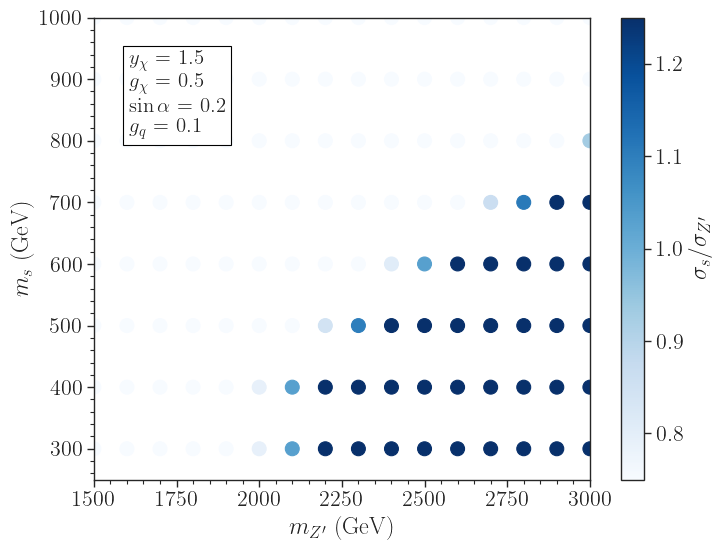

In [12]:
# Plot results
plt.figure(figsize=(8,6))
plt.scatter(x=xsecs['$m_{Zp}$'], y=xsecs['$m_{s}$'], vmin=0.75, vmax=1.25,
            cmap=plt.cm.get_cmap('Blues'), c=xsecs['$\\sigma_{S} / \\sigma_{Zp} (cut)$'], s=100)

cbar=plt.colorbar(label=r'$\sigma_{s} / \sigma_{Z^{\prime}}$')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{s}$ (GeV)')

plt.xlim(1500.0, 3000.0)
plt.ylim(250.0, 1000.0)

plt.text(0.07,0.75,textstr,fontsize=15,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.minorticks_on()
plt.show()

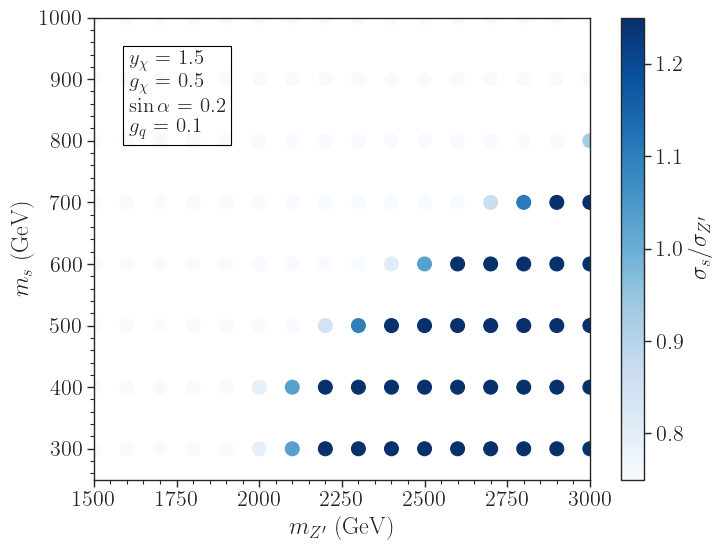

In [13]:
# Plot results
plt.figure(figsize=(8,6))
plt.scatter(x=xsecs['$m_{Zp}$'], y=xsecs['$m_{s}$'], vmin=0.75, vmax=1.25,
            cmap=plt.cm.get_cmap('Blues'), c=xsecs['$\\sigma_{S} / \\sigma_{Zp} (cut)$'], s=100)

cbar=plt.colorbar(label=r'$\sigma_{s} / \sigma_{Z^{\prime}}$')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{s}$ (GeV)')

plt.xlim(1500.0, 3000.0)
plt.ylim(250.0, 1000.0)

plt.text(0.07,0.75,textstr,fontsize=15,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.minorticks_on()
plt.savefig('../../Pictures/map-ratio-3.png')
plt.show()

In [14]:
from itertools import product
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata


pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1400.,100))])
ratios = griddata(list(zip(xsecs['$m_{Zp}$'],xsecs['$m_{s}$'])),
                  np.array(xsecs['$\\sigma_{S} / \\sigma_{Zp} (cut)$']),pts)

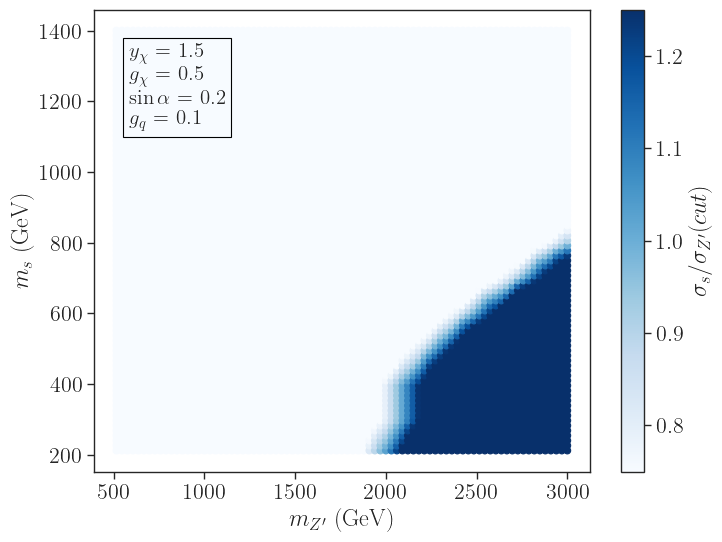

In [15]:
plt.figure(figsize=(8,6))

plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0.75, vmax =1.25, c=ratios, cmap=plt.cm.get_cmap('Blues'))

cbar=plt.colorbar(label=r'$\sigma_{s} / \sigma_{Z^{\prime}} (cut)$')

plt.text(0.07,0.75,textstr,fontsize=15,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{s}$ (GeV)')
plt.show()